# Préparation de la base de données #

On importe les packages qui seront nécessaires pour notre analyse de données. 

In [18]:
!pip install pathlib2
!pip install python-Levenshtein
!pip install openpyxl
!pip install --upgrade xlrd
!pip install pandas fiona shapely pyproj rtree
!pip install pyreadr

import requests
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pyreadr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

## Préparation Préliminaire sur R ##

In [ ]:
#Code sur R pour convertir les parties de la base de données qui nous intéressait en fichier csv
"""
#Spécification du chemin

chemin_csv <- "W:/Documents/3A/SocioQ/movie.csv"

# Exporter la base de données en format CSV
write.csv(movies, file = chemin_csv, row.names = FALSE)
"""

## Importation sur Python et création de la base de données d'intérêt ##

On importe la base de donnée qui nous intéresse. Il s'agit de celle convertie précédemment.

In [7]:
encodage = 'latin-1'
try:
    movie = pd.read_csv('movie.csv', encoding=encodage, sep=',')
except pd.errors.ParserError as e:
    print(f"Error reading CSV file: {e}")

/tmp/ipykernel_241/1916420045.py:3: DtypeWarning: Columns (24,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  movie = pd.read_csv('movie.csv', encoding=encodage, sep=',')


On va supprimer les colonnes pas intéressantes dans le cadre de notre analyse pour faciliter l'implémentation. 

In [9]:
df = movie[['url', 'id', 'note_Presse', 'note_Spectateurs','Distributeur','Budget','Langues', 'Récompense']]
df

,url,id,note_Presse,note_Spectateurs,Distributeur,Budget,Langues,Récompense
0,https://www.allocine.fr/film/fichefilm_gen_cfi...,304685,"4,0","3,9",Gaumont Distribution,-,Français,NaN
1,https://www.allocine.fr/film/fichefilm_gen_cfi...,255726,"4,9","4,3",Universal Pictures International France,-,Anglais,NaN
2,https://www.allocine.fr/film/fichefilm_gen_cfi...,287538,"3,5","3,9",SND,-,Français,NaN
3,https://www.allocine.fr/film/fichefilm_gen_cfi...,277129,"2,7","3,7",Warner Bros. France,-,Anglais,NaN
4,https://www.allocine.fr/film/fichefilm_gen_cfi...,289056,"3,2","4,1",ARP Sélection,-,Anglais,NaN
...,...,...,...,...,...,...,...,...
102905,https://www.allocine.fr/film/fichefilm_gen_cfi...,261493,NaN,NaN,-,-,Anglais,NaN
102906,https://www.allocine.fr/film/fichefilm_gen_cfi...,261515,NaN,NaN,-,-,Japonais,NaN
102907,https://www.allocine.fr/film/fichefilm_gen_cfi...,313983,NaN,NaN,-,-,Anglais,NaN
102908,https://www.allocine.fr/film/fichefilm_gen_cfi...,314869,NaN,NaN,-,-,Anglais,NaN


In [10]:
# Remplacer '--' par NaN et remplacer les virgules par des points dans les colonnes 'note_Presse' et 'note_Spectateurs'
df['note_Presse'] = pd.to_numeric(df['note_Presse'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')
df['note_Spectateurs'] = pd.to_numeric(df['note_Spectateurs'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')

/tmp/ipykernel_241/338836235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['note_Presse'] = pd.to_numeric(df['note_Presse'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')
/tmp/ipykernel_241/338836235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['note_Spectateurs'] = pd.to_numeric(df['note_Spectateurs'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')


In [11]:
df_sans_nan = df.dropna(subset=['note_Presse', 'note_Spectateurs']) #On vire les NaN pour computer la régression

                            OLS Regression Results                            
Dep. Variable:       note_Spectateurs   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     4992.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:22:47   Log-Likelihood:                -8477.7
No. Observations:               10117   AIC:                         1.696e+04
Df Residuals:                   10115   BIC:                         1.697e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2913      0.025     50.924      0.0

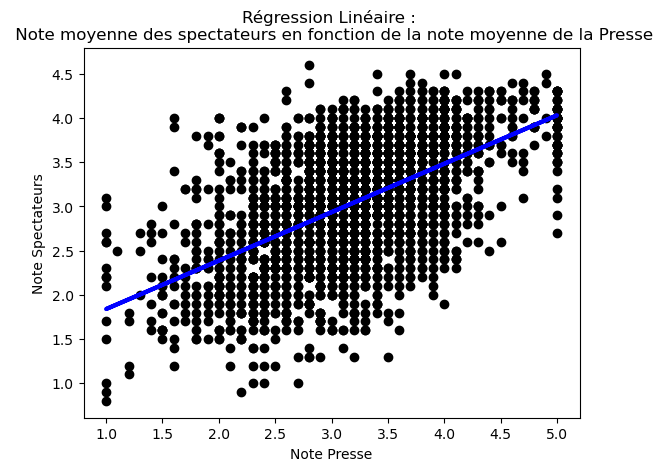

In [22]:
# Sélectionner les colonnes de notes pour la régression linéaire
X = df_sans_nan[['note_Presse']]
y = df_sans_nan['note_Spectateurs']

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputer pour remplacer les NaN par la moyenne dans les données d'entraînement et de test
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajouter une colonne de constantes à X_train_imputed
X_train_imputed = sm.add_constant(X_train_imputed)

# Créer un modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher le résumé du modèle
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance du modèle
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

# Tracer la régression linéaire
plt.scatter(X_test, y_test, color='black')  # Utilisez X_test plutôt que X_test_imputed
plt.plot(X_test, predictions, color='blue', linewidth=3)
plt.xlabel('Note Presse')
plt.ylabel('Note Spectateurs')
plt.title('Régression Linéaire : \n Note moyenne des spectateurs en fonction de la note moyenne de la Presse')
plt.show()

Si on controle par le fait d'avoir reçu une récompense (ce qui peut influencer et la presse et les spectateurs). 

In [26]:
df_sans_nan['Récompense'] = df_sans_nan['Récompense'].notna().astype(int) #Variable binaire pour a été récompensé

/tmp/ipykernel_241/1650299093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sans_nan['Récompense'] = df_sans_nan['Récompense'].notna().astype(int) #Variable binaire pour a été récompensé


In [28]:
df_sans_nan['Récompense']

0        0
1        0
2        0
3        0
4        0
        ..
86540    0
87509    0
93873    0
97227    0
99532    0
Name: Récompense, Length: 12647, dtype: int64

                            OLS Regression Results                            
Dep. Variable:       note_Spectateurs   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     2497.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:29:18   Log-Likelihood:                -8476.8
No. Observations:               10117   AIC:                         1.696e+04
Df Residuals:                   10114   BIC:                         1.698e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2947      0.025     50.810      0.0

ValueError: x and y must be the same size

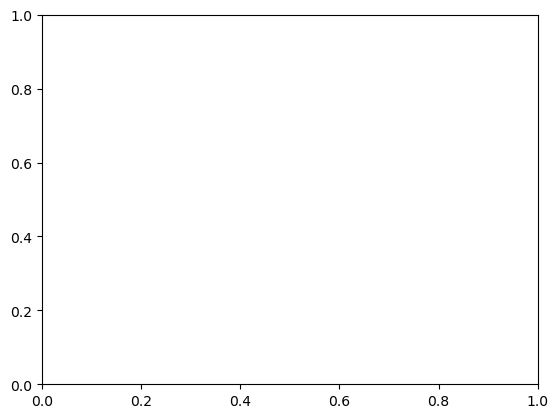

In [27]:
# Sélectionner les colonnes de notes pour la régression linéaire
X = df_sans_nan[['note_Presse', 'Récompense']]
y = df_sans_nan['note_Spectateurs']

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputer pour remplacer les NaN par la moyenne dans les données d'entraînement et de test
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajouter une colonne de constantes à X_train_imputed
X_train_imputed = sm.add_constant(X_train_imputed)

# Créer un modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher le résumé du modèle
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance du modèle
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

"""# Tracer la régression linéaire
plt.scatter(X_test, y_test, color='black')  # Utilisez X_test plutôt que X_test_imputed
plt.plot(X_test, predictions, color='blue', linewidth=3)
plt.xlabel('Note Presse')
plt.ylabel('Note Spectateurs')
plt.title('Régression Linéaire : \n Note moyenne des spectateurs en fonction de la note moyenne de la Presse')
plt.show()"""

In [25]:
df_full_sans_nan['Récompense']

14       1 nomination
16       1 nomination
17       1 nomination
27       1 nomination
35       1 nomination
             ...     
55391          # prix
62226    1 nomination
70800    1 nomination
73365          # prix
85123    1 nomination
Name: Récompense, Length: 1880, dtype: object